In [1]:
import re
import nltk
from nltk.corpus import brown
import pandas as pd

from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.model_selection import train_test_split

from collections import Counter

pstemmer = nltk.PorterStemmer()

%matplotlib inline
import matplotlib.pyplot as plt

from IPython.display import display

In [2]:
df = pd.read_csv("data.csv") #reading from file
colmn = df.content   #column which have reviews

dictofdata={}
i=0
for data in colmn:
    dictofdata[i]=data
    i+=1
dictofdata[10] #checking

"The triple cameras on the iPhone 11 Pro Max now give Apple the best camera phone, thanks to its great Night mode and improved Smart HDR,a huge improvement in battery life Up to 20 hours video playback; up to 12 hours video streaming ... Apple's slow-motion selfies are fun at 120 fps. Apple has given the Pro moniker to the iPhones for the first time. Everything is improved and everything feels better. It comes with a new Lightning to USB Cable with 5W USB Power Adapter. With Display of 6.5-inch Super Retina XDR display with HDR,True Tone, Splash, Water, and Dust Resistant, Water-resistant to a depth of 4 meters for up to 30 minutes (IP68)), Triple 12MP cameras (Ultra Wide, Wide, Telephoto) with Portrait mode, Night mode, Auto Adjustments, next-generation Smart HDR and 4K video up to 60 fps with extended dynamic range."

In [3]:
#Normalize Data
normalizedData = {}
keys = dictofdata.keys()

for key in keys:
    review = dictofdata[key]
    review_as_list_of_sentences = []
    
    for sentence in re.split(r'[.,:;!]', review):
        if sentence:
            sentence = ' '.join([word.lower().strip() for word in sentence.split()])
            review_as_list_of_sentences.append(sentence)
            
    normalizedData[key] = review_as_list_of_sentences

normalizedData[29]

['switch on and off button is not working',
 'looks like given used phone in new box']

In [4]:
# Building backoff tagger for the review data, with specific added training set for 'not'

def build_backoff_tagger_trigram (train_sents):
    t0 = nltk.DefaultTagger("NN")
    t1 = nltk.UnigramTagger(train_sents, backoff = t0)
    t2 = nltk.BigramTagger(train_sents, backoff=t1)
    t3 = nltk.TrigramTagger(train_sents, backoff=t2)
    return t3

sample_sents = brown.tagged_sents(categories=['news', 'editorial', 'reviews'])

addTrainingset = [[('The', 'AT'),  ('battery', 'NN'),  ('is', 'BEZ'),  ('not', 'RB'), ('working', 'VBG'),  ('well', 'RB'), ('.','.')],
                  [('Fast', 'NN'),  ('shipping', 'VBG'),  ('and', 'CC'),  ('everything', 'PN'),  ('however', 'CC'),  ('after', 'IN'),  ('about', 'RB'),  ('two', 'CD'),  ('months', 'NNS'),  ('of', 'IN'),  ('using', 'VBG'),  ('the', 'AT'),  ('phones', 'NNS'), ('white', 'JJ'),  ('lines', 'NNS'),  ('appeared', 'VBD'),  ('on', 'IN'), ('it', 'IN'), ('.','.')],
                  [('The', 'AT'),  ('battery', 'NN'),  ('is', 'BEZ'),  ('not', 'RB'), ('working', 'VBG'),  ('well', 'RB'), ('.','.')],
                  [('After', 'IN'),  ('less', 'AP'),  ('than', 'IN'),  ('six', 'CD'),  ('months', 'NNS'),  ('the', 'AT'),  ('screen', 'NN'), ('is', 'BEZ'),  ('not', 'RB'),  ('working', 'VBG')],
                  [('It', 'PPS'),  ('not', 'RB'),  ('original', 'JJ'),  ('I', 'PPSS'),  ('guess', 'VB')],
                  [('It', 'PPS'),  ('not', 'RB'),  ('original', 'JJ'),  ('I', 'PPSS'),  ('guess', 'VB')],
                  [('It', 'PPS'),  ('not', 'RB'),  ('original', 'JJ'),  ('I', 'PPSS'),  ('guess', 'VB')],
                  [('not', 'RB')]
]

#Training the tagger
ngram_tagger = build_backoff_tagger_trigram(sample_sents + addTrainingset + addTrainingset + addTrainingset + addTrainingset)

In [5]:

tagged_dictionaryData = {}
keys = normalizedData.keys()

for key in keys:
    data = normalizedData[key]
    
    temp = []
    
    for sentence in data:
        x = ngram_tagger.tag(nltk.word_tokenize(sentence))
        temp.append(x)
        
    tagged_dictionaryData[key] = temp
    
#tagged_dictionaryData[1]

In [75]:
#Adding some force tags
force_tags = {'not': 'RB', 'however' : 'CC', 'but' : 'CC'}
keys = tagged_dictionaryData.keys()

for key in keys:
    review = tagged_dictionaryData[key]
    temp_review = []
    for sentence in review:
        if sentence:
            sentence = [(word, force_tags.get(word, tag)) for word, tag in sentence]
            temp_review.append(sentence)
            
    tagged_dictionaryData[key] = temp_review
    
    
#tagged_dictionaryData[20]

In [6]:
#Removing stop words

keys = tagged_dictionaryData.keys()

splitData = {}

for key in keys:
    reviewData = tagged_dictionaryData[key]
    reviewDataList = []

    for sentence in reviewData:
        temp = []
        for word, tag in sentence:
            if tag != 'CC':
                temp.append(word)

            else :
                if temp:
                    sent = ' '.join(temp)
                    reviewDataList.append(sent)
                    temp = []

        #Adding the final temp
        sent = ' '.join(temp)
        reviewDataList.append(sent)
        splitData[key] = reviewDataList
        
#splitData[20]

In [7]:
features={'back': ['processor', 'button', 'camera', 'android', 'back', 'phone', 'nice', 'screen', 'device', 'processor', 'time', 'light', 'first', 'smart', 'cell', 'work', 'great', 'i', 'charger', 'best', 'feature', 'case', 'protector', 'small', 'system', 'lock', 'longer', 'good'], 'battery': ['charge', 'year', 'button', 'phone', 'device', 'life', 'processor', 'time', 'experience', 'battery', 'light', 'first', 'month', 'few', 'cell', 'day', 'work', 'great', 'charger', 'week', 'hour', 'lock'], 'box': ['apple', 'phone', 'original', 'model', 'product', 'great', 'box', 'button', 'glass', 'cell', 'case', 'lock', 'good'], 'button': ['display', 'button', 'camera', 'android', 'price', 'back', 'phone', 'original', 'device', 'computer', 'store', 'life', 'processor', 'time', 'last', 'a', 'battery', 'apple', 'light', 'first', 'condition', 'box', 'cell', 'so', 'inch', 'way', 'deal', 'work', 'product', 'charger', 'same', 'thing', 'lock', 'good'], 'camera': ['processor', 'button', 'camera', 'android', 'back', 'phone', 'nice', 'screen', 'device', 'processor', 'time', 'light', 'first', 'smart', 'cell', 'work', 'great', 'i', 'charger', 'best', 'feature', 'case', 'protector', 'small', 'system', 'lock', 'longer', 'good'], 'cell': ['processor', 'button', 'camera', 'android', 'back', 'phone', 'original', 'nice', 'device', 'life', 'processor', 'battery', 'light', 'quality', 'smart', 'box', 'headphone', 'cell', 'work', 'great', 'i', 'charger', 'best', 'sound', 'lock', 'good'], 'charger': ['apple', 'phone', 'light', 'work', 'device', 'display', 'computer', 'lock', 'charger', 'button', 'camera', 'life', 'processor', 'cell', 'store', 'inch', 'back', 'last', 'battery'], 'connection': ['device', 'connection', 'service', 'delivery', 'seller', 'fast', 'internet', 'system', 'hardware'], 'device': ['charge', 'display', 'button', 'camera', 'glass', 'android', 'back', 'phone', 'device', 'computer', 'screen', 'store', 'life', 'processor', 'time', 'last', 'hardware', 'battery', 'brand', 'apple', 'light', 'first', 'cell', 'design', 'inch', 'hand', 'work', 'connection', 'charger', 'internet', 'system', 'protector', 'lock', 'longer'], 'display': ['light', 'model', 'screen', 'display', 'device', 'charger', 'button', 'processor', 'protector', 'inch', 'lock', 'longer'], 'hardware': ['apple', 'accessory', 'device', 'connection', 'processor', 'store', 'internet', 'system', 'hardware'], 'headphone': ['phone', 'smart', 'nice', 'work', 'great', 'i', 'headphone', 'best', 'cell', 'android', 'good'],  'light': ['perfect', 'display', 'button', 'camera', 'back', 'phone', 'device', 'computer', 'store', 'life', 'processor', 'carrier', 'last', 'battery', 'order', 'apple', 'light', 'condition', 'cell', 'inch', 'way', 'work', 'great', 'charger', 'lock', 'good'], 'phone': ['bad', 'charge', 'processor', 'review', 'button', 'serial', 'camera', 'android', 'use', 'price', 'back', 'phone', 'original', 'nice', 'star', 'device', 'buy', 'life', 'processor', 'time', 'last', 'a', 'experience', 'number', 'battery', 'apple', 'light', 'quality', 'smart', 'condition', 'first', 'box', 'headphone', 'service', 'cell', 'issue', 'so', 'better', 'music', 'couple', 'much', 'way', 'deal', 'work', 'one', 'product', 'great', 'i', 'charger', 'best', 'same', 'thing', 'sound', 'lock', 'feature', 'good'], 'processor': ['apple', 'phone', 'smart', 'nice', 'work', 'great', 'i', 'processor', 'manufacturer', 'best', 'store', 'cell', 'camera', 'android', 'carrier', 'back', 'hardware', 'good'], 'system': ['hardware', 'device', 'connection', 'camera', 'internet', 'design', 'system', 'small', 'back', 'feature']}

In [8]:

# Ca

reviews_perFeature = {}
for review_id in splitData:
       review_phrases = splitData[review_id]
       for phrase in review_phrases:
           phrase_words = phrase.split(' ')
           set1 = set(phrase_words)
           for term in features:
               set2 = set([term])
               result = set1.intersection(set2)
               if result:
                   if term in reviews_perFeature: 
                       reviews_perFeature[term].append(phrase)
                   else:
                       reviews_perFeature[term] = [phrase]
                        
for i in range(5):
    print(reviews_perFeature['camera'][i])

the triple cameras on the iphone 11 pro max now give apple the best camera phone
night mode is better than any available camera
optical zoom in camera is still 2x
the camera
4k video recording support on front camera is an additional bonus


In [9]:
#converting dict to panda table

df_dict = {}
for aspect in reviews_perFeature:
    tempdict= {}
    tempdict['Text'] = reviews_perFeature[aspect]
    temp_df = pd.DataFrame(tempdict)
    df_dict[aspect] = temp_df
    
df_dict['battery']

,Text
0,a huge improvement in battery life up to 20 ho...
1,battery life
2,a huge improvement in battery life up to 20 ho...
3,battery life
4,a huge improvement in battery life up to 20 ho...
5,battery life
6,a huge improvement in battery life up to 20 ho...
7,battery life
8,a huge improvement in battery life up to 20 ho...
9,battery life


In [10]:
#Sentiment analysis

# Fetching the labelled data and training the classifier
train_data_file_name = 'train_data.csv'


train_data_df = pd.read_csv(train_data_file_name, encoding = "ISO-8859-13")
train_data_df.columns = ["Text","Sentiment"]

In [11]:
# Stemming, tokenizing and vectorizing the features
stemmer = pstemmer
def stem_tokens(tokens, stemmer):
    stemmed = []
    for item in tokens:
        stemmed.append(stemmer.stem(item))
    return stemmed

def tokenize(text):
    # remove non letters
    text = re.sub("[^a-zA-Z]", " ", text)
    # tokenize
    tokens = nltk.word_tokenize(text)
    # stem
    stems = stem_tokens(tokens, stemmer)
    return stems

# vectorizer = CountVectorizer(
#     analyzer = 'word', # Assigning analyzer as word
#     tokenizer = tokenize,
#     lowercase = True, # Lowercasing the words
#     stop_words = 'english', # For removing stop words from being considered as features
#     ngram_range = (1,3), # Allowing unigrams, bigrams, and trigrams to be considered as features
#     max_features = 50 # Using the top 1000 features
# )

vectorizer = TfidfVectorizer(
    analyzer = 'word',
    min_df=1,
    tokenizer = tokenize,
    lowercase = True,
    stop_words = 'english',
    ngram_range = (1,3),
    max_features = 1000
)

In [12]:
# Extracting the features from training data
corpus_data_features = vectorizer.fit_transform(train_data_df.Text.tolist())

/home/rishiawsm/anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'afterward', 'alon', 'alreadi', 'alway', 'ani', 'anoth', 'anyon', 'anyth', 'anywher', 'becam', 'becaus', 'becom', 'befor', 'besid', 'cri', 'describ', 'dure', 'els', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'formerli', 'forti', 'ha', 'henc', 'hereaft', 'herebi', 'hi', 'howev', 'hundr', 'inde', 'latterli', 'mani', 'meanwhil', 'moreov', 'mostli', 'nobodi', 'noon', 'noth', 'nowher', 'onc', 'onli', 'otherwis', 'ourselv', 'perhap', 'pleas', 'seriou', 'sever', 'sinc', 'sincer', 'sixti', 'someon', 'someth', 'sometim', 'somewher', 'themselv', 'thenc', 'thereaft', 'therebi', 'therefor', 'thi', 'thu', 'togeth', 'twelv', 'twenti', 'veri', 'wa', 'whatev', 'whenc', 'whenev', 'wherea', 'whereaft', 'wherebi', 'wherev', 'whi', 'yourselv'] not in stop_wor

In [13]:
# Feature to array
corpus_data_features_nd = corpus_data_features.toarray()
corpus_data_features_nd.shape

# Removing features with less than 3 characters
vocab = vectorizer.get_feature_names()
vocab = [word.lower() for word in vocab if len(word) > 2]

In [14]:
# remember that corpus_data_features_nd contains all of our 
# original train and test data, so we need to exclude
# the unlabeled test entries

X_train, X_dev, y_train, y_dev  = train_test_split(
        corpus_data_features_nd, 
        train_data_df.Sentiment,
        train_size=0.99, 
        random_state=1234)

In [15]:
# Training the classifier on the whole training data available
rf_model = RandomForestClassifier(n_estimators=1000)
rf_model = rf_model.fit(X=corpus_data_features_nd, y=train_data_df.Sentiment)

In [16]:
# Performing predictions on the dev set

predictions_dict = {}
for feature in df_dict:
    test_data_df = df_dict[feature]
    corpus_data_features_test_vector = vectorizer.transform(test_data_df.Text.tolist())
    corpus_data_features_test = corpus_data_features_test_vector.toarray()
        
    test_log_pred = rf_model.predict(corpus_data_features_test)
    predictions_dict[feature] = test_log_pred

In [17]:
predictions_dict

{'camera': array([1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1,
        1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0,
        0, 1, 1, 1, 0, 0]),
 'phone': array([ 1, -1,  0, -1, -1, -1,  0,  1, -1,  0,  1,  1, -1,  0, -1, -1, -1,
         0,  1, -1,  0,  1,  1, -1,  0, -1, -1, -1,  0,  1, -1,  0,  1,  1,
        -1,  0, -1, -1, -1,  0,  1, -1,  0,  1,  1, -1,  0, -1, -1, -1,  0,
         1, -1,  0,  1,  1, -1,  0, -1, -1, -1,  0,  1, -1,  0,  1,  1, -1,
         0, -1, -1, -1,  0,  1, -1,  0,  1,  1, -1,  0, -1, -1, -1,  0,  1,
        -1,  0,  1,  1, -1,  0, -1, -1, -1,  0,  1, -1,  0,  1,  1, -1,  0,
        -1, -1, -1,  0,  1, -1,  0,  1]),
 'battery': array([-1,  1, -1,  1, -1,  1, -1,  1, -1,  1, -1,  1, -1,  1, -1,  1, -1,
         1, -1,  1]),
 'display': array([0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1,
        0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0,
        1, 0, 1, 0, 0, 1]),
 'device': 

In [18]:
def plot_Results(predictions_dict):
    # Variables for Product Attributes
    attr_list = []
    
    #Variables for device
    overall_list = []
    
    # Defining dictionaries for storing counts for overall device sentiment
    overall_dict = {'No Of Positive mentions' : 0, 'No Of Negative mentions' : 0}
            
    # Assigning index name to dictionaries for overall counts
    overall_dict['Aspect'] = 'device'
    
    for aspect in predictions_dict:
        if aspect not in ['phone', 'device', 'cell', 'smartphone', 'telephone', 'mobile']:

            # Defining dictionaries for storing counts
            attr_dict = {'No Of Positive mentions' : 0, 'No Of Neutral mentions' : 0, 
                                 'No Of Negative mentions' : 0}
            
            # Assigning index name
            attr_dict['Aspect'] = aspect
            
            # Calculating counts of different sentiments
            list_counter = predictions_dict[aspect]
            count = Counter(list_counter)
            
            # Storing the counts in the dictionaries
            if 1 in count:
                attr_dict['No Of Positive mentions'] = count[1]
                
            if 0 in count:
                attr_dict['No Of Neutral mentions'] = count[0] 
                
            if -1 in count:
                attr_dict['No Of Negative mentions'] = count[-1]
            
            # Appending dictionaries to lists for easier dataframe manipulation
            attr_list.append(attr_dict)
            
        else :
            # Calculating counts of different sentiments for the product
            list_counter = predictions_dict[aspect]
            count = Counter(list_counter)
            
            if 1 in count:
                overall_dict['No Of Positive mentions'] += count[1]
               
            # Commenting out code for the 'maybe' sentiment
#             if 0 in count:
#                 overall_dict['No Of Neutral mentions'] += count[0]
            
            if -1 in count:
                overall_dict['No Of Negative mentions'] += count[-1]
    
    # Appending dictionaries to lists for easier dataframe manipulation
    overall_list.append(overall_dict)

    # For overall product
    df_overall = pd.DataFrame(overall_list)
    df_overall_final= df_overall.set_index('Aspect')
    
    #For printing the re-call table for attributes
    df_attr = pd.DataFrame(attr_list)
    df_attr_final = df_attr.set_index("Aspect")
    
    print("----------------------")
    print("Apsects and number of related phrases for Iphone 11Pro")
    print("----------------------")
    
    display(df_attr_final)
    
    print("\n----------------------")
    print("Graph of sentiments for different attributes")
    print("----------------------")
    df_attr_final.plot(kind='bar', color=['g','b','r'],figsize=(12, 10))
    plt.savefig("iphone11pro.png")
    df_attr_final.to_csv('attr_df.csv')

----------------------
Apsects and number of related phrases for Iphone 11Pro
----------------------


,No Of Positive mentions,No Of Neutral mentions,No Of Negative mentions
Aspect,,,
camera,30,20,0
battery,10,0,10
display,20,30,0
system,10,0,0
button,0,0,10
box,10,0,0



----------------------
Graph of sentiments for different attributes
----------------------


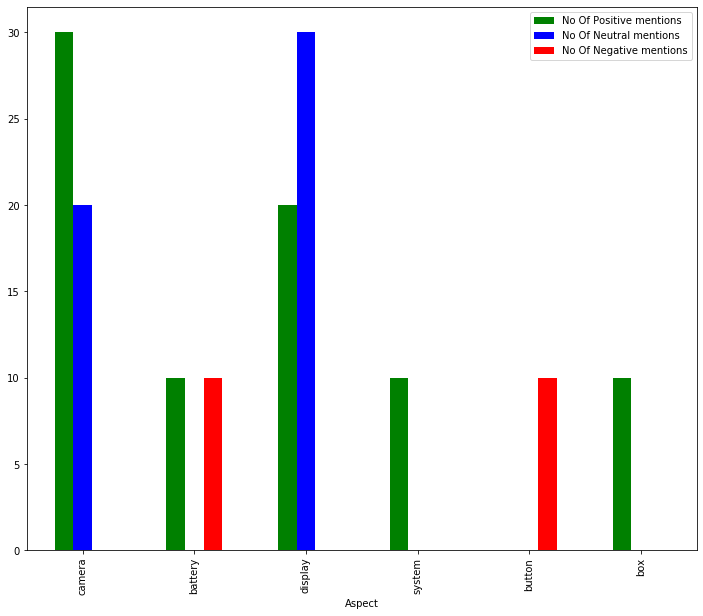

In [19]:
plot_Results(predictions_dict)